# Capstone Two - 4 Pre-Processing and ARIMA Model<a id='4'></a>

## 4.1 Contents<a id='4.1'></a>
* [4 Pre-Processing and ARIMA model](#4)
  * [4.1 Contents](#4.1)
  * [4.2 Imports](#4.2)
  * [4.3 Load The Data](#4.3)
  * [4.4 Processing Categorical Variables](#4.4)
  * [4.5 Processing Sales Data](#4.5)
  * [4.6 Time Series Components](#4.6)
    * [4.6.1 Decomposition](#4.6.1)
    * [4.6.2 Stationarity testing](#4.6.2)
  * [4.7 The ARIMA Model](#4.7) 
    * [4.7.1 Make a function to find the MSE of a single ARIMA model](#4.7.1)
    * [4.7.2 Make a function to evaluate the different ARIMA models with different p, d, and q values](#4.7.2)
    * [4.7.3 Visualize model results](#4.7.3)
    * [4.7.4 Forecasting](#4.7.4)
    * [4.7.5 Evaluate the performance of the model forecasts](#4.7.5)
  * [4.8 Regression Model](#4.8)
    * [4.8.1 Exogenous Variables](#4.8.1)
    * [4.8.2 Linear Regression model](#4.8.2)
    * [4.8.3 Random Forest model](#4.8.3)
  * [4.9 Models' Performance Comparison](#4.9)
    

## 4.2 Imports<a id='4.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# kpss for stationary test
from statsmodels.tsa.stattools import kpss

# import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# for regression model
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

# save data in a file
from library.sb_utils import save_file

## 4.3 Load The Data<a id='4.3'></a>

In [2]:
data_dir = '../data/'

# Grocery sales at store No.44
data = pd.read_csv(data_dir+'train_selected_group.csv')

## 4.4 Processing Categorical Features<a id='4.4'></a>

Create dummy or indicator features for categorical variables: day_of_week and holiday.

In [3]:
# Weekday or Weekend
data.loc[data['day_of_week'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday']), 'day_of_week'] = 'weekday'
data.loc[data['day_of_week'].isin(['Saturday','Sunday']), 'day_of_week'] = 'weekend'

In [4]:
# Weekend but Workday -> Weekday
data.loc[data['holiday_type'] == 'Work Day', 'day_of_week'] = 'weekday'

In [5]:
# Holiday or Non_holiday
data.loc[ (data['holiday_type'] == 'Holiday') & (data['transferred'] == False), 'holiday_type'] = 'holiday'
data.loc[ (data['holiday_type'] == 'Holiday') & (data['transferred'] == True), 'holiday_type'] = 'non_holiday'
data.loc[ data['holiday_type'].isin(['Additional','Bridge','Event','Transfer']), 'holiday_type'] = 'holiday'
data.loc[ data['holiday_type'].isin(['Normal','Work Day']), 'holiday_type'] = 'non_holiday'

In [6]:
dummy_hol = pd.get_dummies(data['holiday_type'])
dummy_hol.head()

,holiday,non_holiday
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [7]:
dummy_dow = pd.get_dummies(data['day_of_week'])
dummy_dow.head()

,weekday,weekend
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [8]:
data = pd.concat([data, dummy_hol], axis=1)
data = pd.concat([data, dummy_dow], axis=1)

In [9]:
data.drop(['holiday_type', 'transferred', 'day_of_week'], axis=1, inplace=True)
data.drop(['sales_lag1', 'sales_lag2', 'sales_lag3', 'sales_3_day_avg', 'sales_week_avg'], axis=1, inplace=True)

In [10]:
data.head()

,date,sales,onpromotion,dcoilwtico,transactions,holiday,non_holiday,weekday,weekend
0,2013-01-01,0.0,0.0,93.14,0.0,1,0,1,0
1,2013-01-02,10686.0,0.0,93.14,4821.0,0,1,1,0
2,2013-01-03,7342.0,0.0,92.97,3618.0,0,1,1,0
3,2013-01-04,7250.0,0.0,93.12,4169.0,0,1,1,0
4,2013-01-05,10699.0,0.0,93.12,4921.0,0,1,1,0


Note that on the first date "2013-01-01", the store was colsed so the sales was zero. And the first 7 rows of the "lag" columns were NaN.

## 4.5 Processing Sales Data<a id='4.5'></a>

Let's type convert the `date` column to a Python datetime, before making that the index.

In [11]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

Making a predictor variable y:

In [12]:
y = data['sales']

In [13]:
# Drop "2013-01-01" value since it's zero.
y.drop(labels=['2013-01-01'], inplace=True)

In [14]:
type(y)

pandas.core.series.Series

Getting summary statistics for y:

In [15]:
y.describe()

count     1687.000000
mean      9760.911970
std       3537.978965
min       2990.000000
25%       7293.000000
50%       8809.000000
75%      11665.000000
max      46271.000000
Name: sales, dtype: float64

Plotting y:

<AxesSubplot:xlabel='date'>

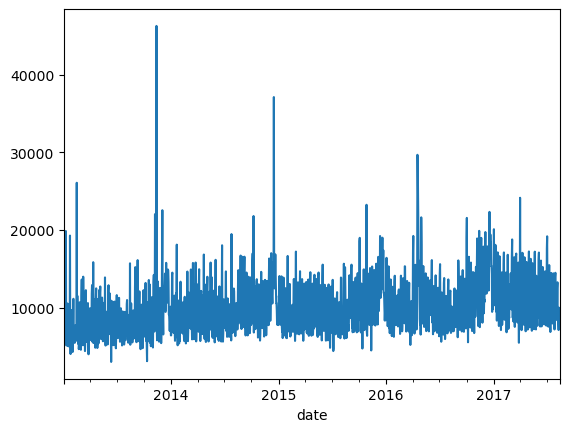

In [16]:
y.plot()

## 4.6 Time Series Components<a id='4.6'></a>

### 4.6.1 Decomposition<a id='4.6.1'></a>

we can use the decompose() function to quantify the component parts described above in our data.

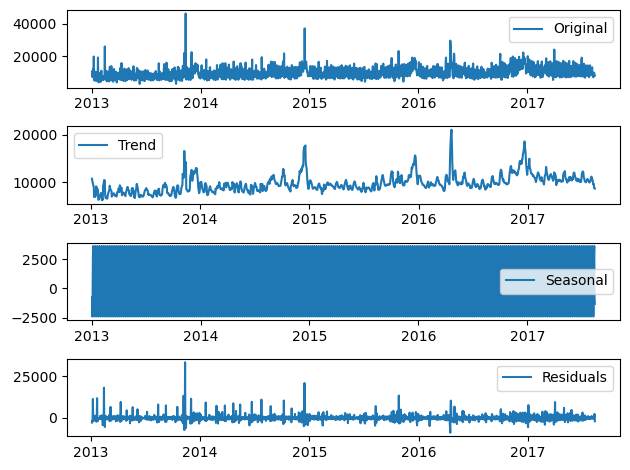

In [17]:
# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 4.6.2 Stationarity testing<a id='4.6.2'></a>

Testing for stationarity with KPSS:

In [18]:
# Use kpss()
kpss(y)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(4.484627548650581,
 0.01,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.01, we should reject the Null hypothesis and deduce the non-stationarity of our data.

But our data need to be stationary! So we need to do some transforming.

**Making the data stationary:**

In [19]:
# Declare a variable called y_log
y_log = np.log(y)

<AxesSubplot:xlabel='date'>

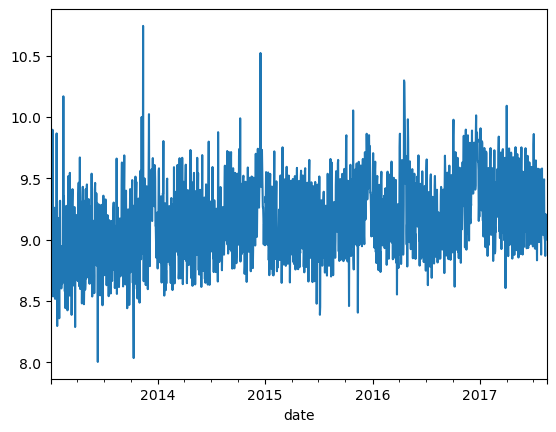

In [20]:
y_log.plot()

We can try to make this time series stationary by differencing our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

We can use the diff() function to take the difference between the existing values.

In [21]:
kpss(y_log.diff().dropna())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.04091697403043888,
 0.1,
 55,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.1, so we can accept the null hypothesis that our data is **stationary**.

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots:

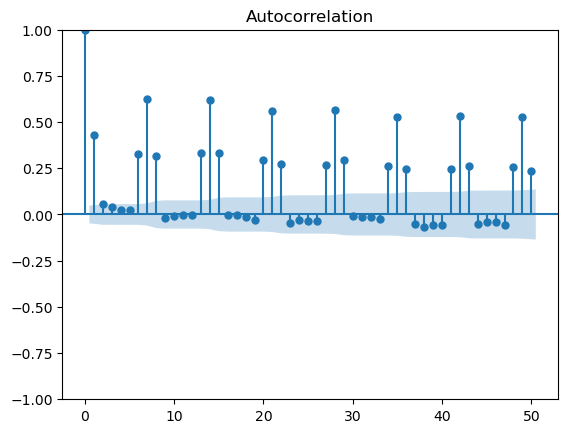

In [22]:
plot_acf(y_log, lags=50);

We have a correlation with 1, 6 and 7 day sales in the past.

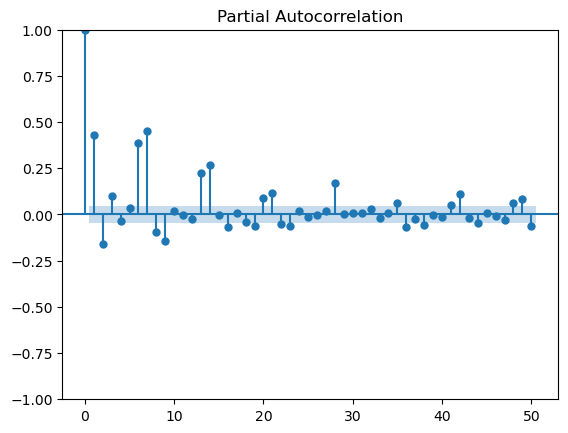

In [23]:
plot_pacf(y_log, lags=50, method='ywm');

The PACF is exponentially decaying and there are significant spikes at lag 1 and lags 6-8, 13-15 in the ACF.

## 4.7 The ARIMA Model<a id='4.7'></a>

### 4.7.1 Make a function to find the MSE of a single ARIMA model<a id='4.7.1'></a>

ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

**Train-Test Split:** Since the forecasting horizon is 16 days, we also set the testing set to 16 days. 

In [24]:
split=1687-16 #int(len(data) * 0.8) #
# Make train and test variables, with 'train, test'
ylog_train, ylog_test = y_log[0:split], y_log[split:len(y_log)]

In [25]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(train, test, arima_order):
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error and predictions
    return error, predictions

### 4.7.2 Make a function to evaluate the different ARIMA models with different p, d, and q values<a id='4.7.2'></a>

In [26]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(trainset, testset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse, pred = evaluate_arima_model(trainset, testset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.12f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.12f' % (best_cfg, best_score))

In [27]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 2)]
d_values = [x for x in range(0, 2)]
q_values = [x for x in [1,6,7,8,13,14,15]]

In [28]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(ylog_train, ylog_test, p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=0.022935433181\
ARIMA(0, 0, 6) MSE=0.021289004322\
ARIMA(0, 0, 7) MSE=0.016921610445\
ARIMA(0, 0, 8) MSE=0.016940108783\
ARIMA(0, 0, 13) MSE=0.015255955632\
ARIMA(0, 0, 14) MSE=0.013687016345\
ARIMA(0, 0, 15) MSE=0.014994626605\
ARIMA(0, 1, 1) MSE=0.031826500254\
ARIMA(0, 1, 6) MSE=0.027389352882\
ARIMA(0, 1, 7) MSE=0.023819812554\
ARIMA(0, 1, 8) MSE=0.022898426168\
ARIMA(0, 1, 13) MSE=0.018463250210\
ARIMA(0, 1, 14) MSE=0.017415795123\
ARIMA(0, 1, 15) MSE=0.018423731154\
ARIMA(1, 0, 1) MSE=0.023344458126\
ARIMA(1, 0, 6) MSE=0.025745310974\
ARIMA(1, 0, 7) MSE=0.017462249053\
ARIMA(1, 0, 8) MSE=0.016757881347\
ARIMA(1, 0, 13) MSE=0.016747833619\
ARIMA(1, 0, 14) MSE=0.014521155309\
ARIMA(1, 0, 15) MSE=0.015094987083\
ARIMA(1, 1, 1) MSE=0.029208585077\
ARIMA(1, 1, 6) MSE=0.027080946219\
ARIMA(1, 1, 7) MSE=0.023413449801\
ARIMA(1, 1, 8) MSE=0.023239048036\
ARIMA(1, 1, 13) MSE=0.018233136223\
ARIMA(1, 1, 14) MSE=0.017788955979\
ARIMA(1, 1, 15) MSE=0.019278569067\
Best ARIMA(0, 0, 14) MSE=0.013687016345

So the best p,d, q, parameters for our ARIMA model are 0, 0, 14 respectively. It's a MA(14) model. Now we know this, we can build the model using the training set.

In [29]:
p,d,q = (0,0,14)
model = ARIMA(ylog_train, order=(p,d,q))
model_fit = model.fit()

In [30]:
# Call summary() on model_fit
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1671
Model:                ARIMA(0, 0, 14)   Log Likelihood                 -40.173
Date:                Thu, 13 Jul 2023   AIC                            112.347
Time:                        09:18:15   BIC                            199.086
Sample:                    01-02-2013   HQIC                           144.486
                         - 07-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1309      0.017    540.430      0.000       9.098       9.164
ma.L1          0.3371      0.018     19.189      0.000       0.303       0.372
ma.L2          0.0318      0.023      1.367      0.172      -0.014       0.077
ma.L3          0.0603      0.025      2.369      0.018       0.010       0.110
ma.L4          0.0196      0.024      0.824      0.410      -0.027       0.066
ma.L5          0.0139      0.022      0.645      0.519      -0.028       0.056
ma.L6          0.1429      0.021      6.863      0.000       0.102       0.184
ma.L7          0.3944      0.021     19.152      0.000       0.354       0.435
ma.L8          0.1204      0.024      5.004      0.000       0.073       0.168
ma.L9         -0.0634      0.026     -2.450      0.014      -0.114      -0.013
ma.L10        -0.0149      0.025     -0.593      0.553      -0.064       0.034
ma.L11         0.0300      0.025      1.211      0.226      -0.019       0.079
ma.L12        -0.0004      0.025     -0.014      0.989      -0.049       0.049
ma.L13         0.1794      0.023      7.919      0.000       0.135       0.224
ma.L14         0.2960      0.022     13.233      0.000       0.252       0.340
sigma2         0.0614      0.002     37.473      0.000       0.058       0.065
===================================================================================
Ljung-Box (L1) (Q):                   2.56   Jarque-Bera (JB):               920.25
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4.7.3 Visualize model results<a id='4.7.3'></a>

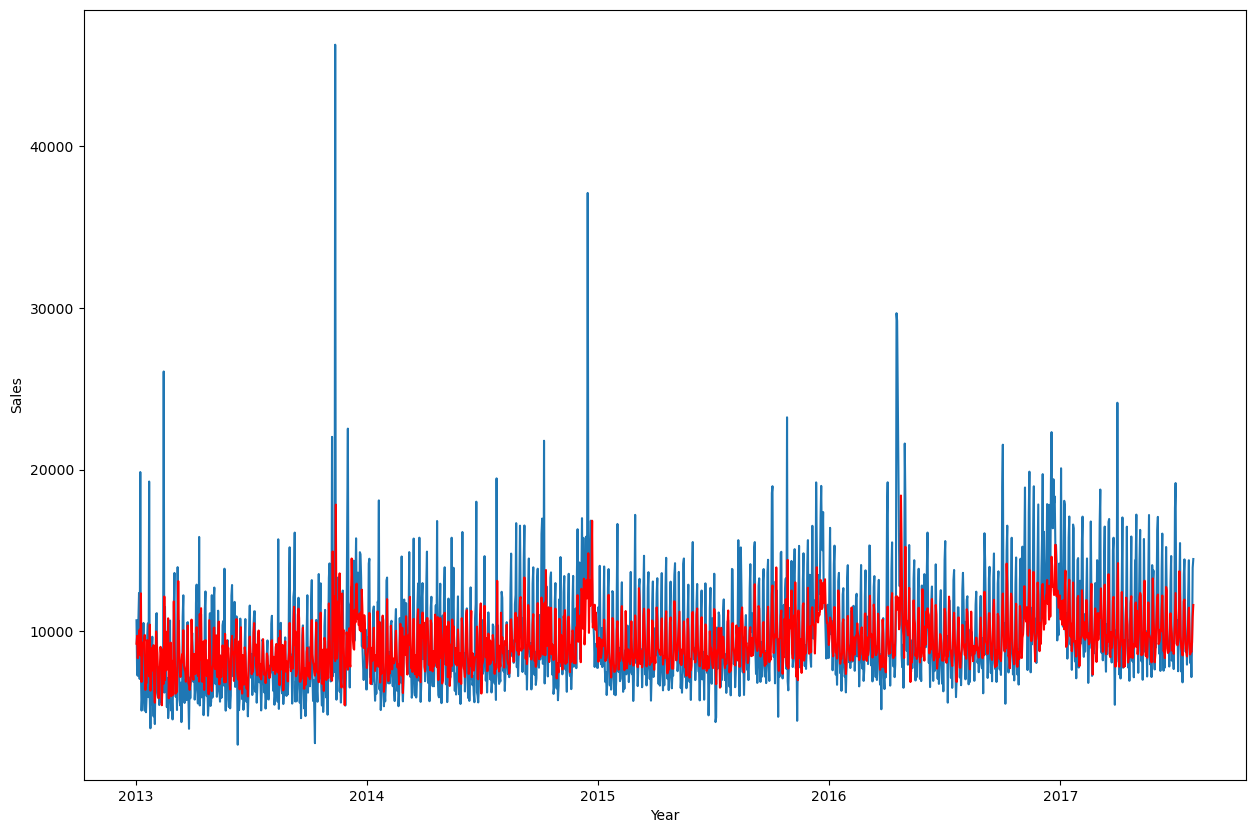

In [31]:
y_train = y[0:split]
y_fit = np.exp(model_fit.predict())
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_train)
plt.plot(y_fit, color = 'red')
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()

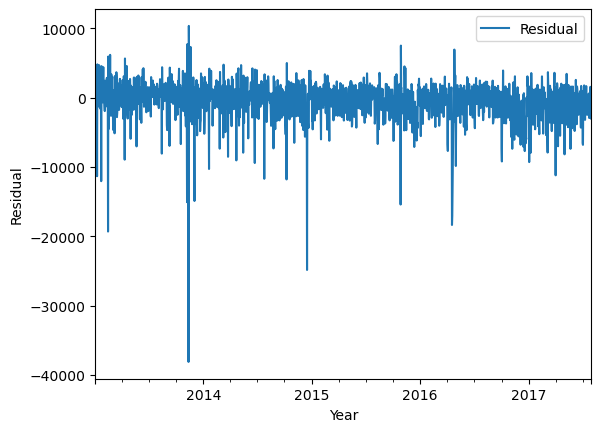

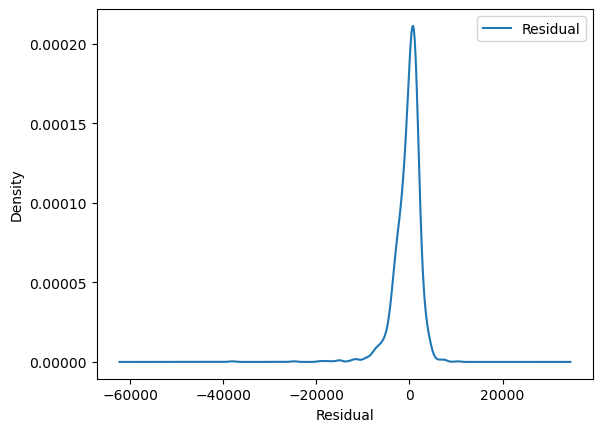

In [32]:
# Model diagnostics
y_resid = y_fit - y_train
residuals = pd.DataFrame(y_resid, columns=['Residual'])  # model_fit.resid
residuals.plot()
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

residuals.plot(kind='kde') #Kernel Distribution Estimation Plot
plt.xlabel("Residual")
plt.show()

### 4.7.4 Forecasting<a id='4.7.4'></a>

In [33]:
order=(p,d,q)
ylog_mse, ylog_pred = evaluate_arima_model(ylog_train, ylog_test, order)
ylog_pred

[9.201705313471818,
 9.109530333073687,
 9.193496970552996,
 9.122261970411492,
 9.187559075580388,
 9.344828881962686,
 9.332030223652714,
 9.185337251942054,
 9.149548590938721,
 9.119825313593248,
 8.992610763997027,
 9.093962585329768,
 9.326072419256963,
 9.189071766422579,
 9.101461570833463,
 9.073018631509736]

In [34]:
ylog_mse

0.01368701634470561

In [35]:
#original variable: y_pred
y_pred = np.exp(ylog_pred)
y_pred

array([ 9914.02116533,  9041.04761307,  9832.97655592,  9156.89082452,
        9774.76237974, 11439.51514909, 11294.03764771,  9753.06869033,
        9410.19157411,  9134.60578558,  8043.42900168,  8901.38877187,
       11226.95002647,  9789.55976239,  8968.39106787,  8716.89723152])

In [36]:
y_true = y[split:len(y)] #same with: np.exp(ylog_test)
y_true

date
2017-07-31     9934.0
2017-08-01    10941.0
2017-08-02    11156.0
2017-08-03     8419.0
2017-08-04     9346.0
2017-08-05    12463.0
2017-08-06    13248.0
2017-08-07     8497.0
2017-08-08     8201.0
2017-08-09     8062.0
2017-08-10     7097.0
2017-08-11     9979.0
2017-08-12     9391.0
2017-08-13     9811.0
2017-08-14     8318.0
2017-08-15     8123.0
Name: sales, dtype: float64

### 4.7.5 Evaluate the performance of the model forecasts<a id='4.7.5'></a>

In [37]:
# APE = ABS((actual - predicted) / actual)
APE_ma = abs( (y_true - y_pred) / y_true) # ma: moving average model

In [38]:
# MEAN(APE)
mAPE_ma = np.mean(APE_ma)
print('MA(14) MAPE:')
mAPE_ma

MA(14) MAPE:


0.10475264042718785

In [39]:
print('R-squared: Training, Testing')
r2_score(y_train, y_fit), r2_score(y_true, y_pred)

R-squared: Training, Testing


(0.34622931964824066, 0.5050457521466623)

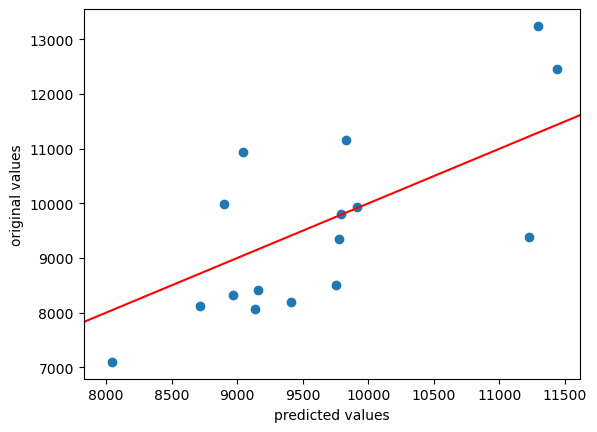

In [40]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y_pred, y_true)
plt.xlabel("predicted values")
plt.ylabel("original values")
ax.axline((8000, 8000), slope=1, color = 'red')
plt.show()

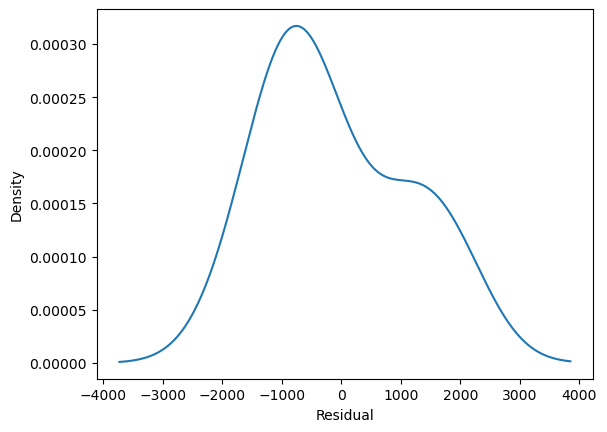

In [41]:
# Residual = actual - predicted
y_resid_ma = y_true - y_pred  # ma: moving average model
y_resid_ma.plot(kind='kde') #Kernel Distribution Estimation Plot
plt.xlabel("Residual")
plt.show()

In [42]:
# R-Squared
# r2_score(y_true, y_pred)
SS_resid = sum( (y_resid_ma)**2 )
SS_total = sum( (y_true - np.mean(y_true))**2 )
R2 = 1 - SS_resid/SS_total
R2

0.5050457521466623

In [43]:
# Adjusted R-Squared
n = len(y_true)
k = 14+1 #number of parameters
R2_ajust = 1 - (SS_resid/(n-k)) / (SS_total/(n-1))
R2_ajust

-6.424313717800065

**Brief Summary:**

The MA(14) model is useful for this time series forecasting, since it has a MAPE of about 10%.

## 4.8 Regression Model<a id='4.8'></a>

### 4.8.1 Exogenous Variables<a id='4.8.1'></a>

In [44]:
data.head()

,sales,onpromotion,dcoilwtico,transactions,holiday,non_holiday,weekday,weekend
date,,,,,,,,
2013-01-01,0.0,0.0,93.14,0.0,1,0,1,0
2013-01-02,10686.0,0.0,93.14,4821.0,0,1,1,0
2013-01-03,7342.0,0.0,92.97,3618.0,0,1,1,0
2013-01-04,7250.0,0.0,93.12,4169.0,0,1,1,0
2013-01-05,10699.0,0.0,93.12,4921.0,0,1,1,0


Our target is `sales`, and we have several Exogenous Variables: `onpromotion` (number of promotional products), `dcoilwtico` (daily oil price), `transactions` (number of total transactions), `holiday/non_holiday`, `weekday/weekend`.

From the above ACF and PACF plots, plus we know the best fitted ARIMA model is MA(14) model, we choose the **lagging window of 1, 7, and 14 days**.

The lagged features we choose are 1-day, 7-day, 14-day lagged values and the average of last 7 or 14 days' values.

In [45]:
# For sales
data['sales_lag1'] = data['sales'].shift(1)
data['sales_lag7'] = data['sales'].shift(7)
data['sales_lag14'] = data['sales'].shift(14)

# previous 7 days' average
data['sales_7days_avg'] = data['sales_lag1'].rolling(7).mean().round(1)
# previous 14 days's average
data['sales_14days_avg'] = data['sales_lag1'].rolling(14).mean().round(1)

In [46]:
# For transactions
data['trans_lag1'] = data['transactions'].shift(1)
data['trans_lag7'] = data['transactions'].shift(7)
data['trans_lag14'] = data['transactions'].shift(14)

# previous 7 days' average
data['trans_7days_avg'] = data['trans_lag1'].rolling(7).mean().round(1)
# previous 14 days's average
data['trans_14days_avg'] = data['trans_lag1'].rolling(14).mean().round(1)

In [47]:
# For oil price
data['oil_lag1'] = data['dcoilwtico'].shift(1)
data['oil_lag7'] = data['dcoilwtico'].shift(7)
data['oil_lag14'] = data['dcoilwtico'].shift(14)

# previous 7 days' average
data['oil_7days_avg'] = data['oil_lag1'].rolling(7).mean().round(2)
# previous 14 days's average
data['oil_14days_avg'] = data['oil_lag1'].rolling(14).mean().round(2)

In [48]:
data.head(20)

,sales,onpromotion,dcoilwtico,transactions,holiday,non_holiday,weekday,weekend,sales_lag1,sales_lag7,...,trans_lag1,trans_lag7,trans_lag14,trans_7days_avg,trans_14days_avg,oil_lag1,oil_lag7,oil_lag14,oil_7days_avg,oil_14days_avg
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,93.14,0.0,1,0,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,10686.0,0.0,93.14,4821.0,0,1,1,0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,93.14,NaN,NaN,NaN,NaN
2013-01-03,7342.0,0.0,92.97,3618.0,0,1,1,0,10686.0,NaN,...,4821.0,NaN,NaN,NaN,NaN,93.14,NaN,NaN,NaN,NaN
2013-01-04,7250.0,0.0,93.12,4169.0,0,1,1,0,7342.0,NaN,...,3618.0,NaN,NaN,NaN,NaN,92.97,NaN,NaN,NaN,NaN
2013-01-05,10699.0,0.0,93.12,4921.0,0,1,1,0,7250.0,NaN,...,4169.0,NaN,NaN,NaN,NaN,93.12,NaN,NaN,NaN,NaN
2013-01-06,12373.0,0.0,93.12,4925.0,0,1,0,1,10699.0,NaN,...,4921.0,NaN,NaN,NaN,NaN,93.12,NaN,NaN,NaN,NaN
2013-01-07,7059.0,0.0,93.20,3871.0,0,1,1,0,12373.0,NaN,...,4925.0,NaN,NaN,NaN,NaN,93.12,NaN,NaN,NaN,NaN
2013-01-08,19849.0,0.0,93.21,3593.0,0,1,1,0,7059.0,0.0,...,3871.0,0.0,NaN,3760.7,NaN,93.20,93.14,NaN,93.12,NaN
2013-01-09,7546.0,0.0,93.08,4006.0,0,1,1,0,19849.0,10686.0,...,3593.0,4821.0,NaN,4274.0,NaN,93.21,93.14,NaN,93.13,NaN


From the EDA part, we know that the oil price fell sharply in 2014, so we will start our training set from "2015-01-01".

In [49]:
df=data[730:]
df.head(3)

,sales,onpromotion,dcoilwtico,transactions,holiday,non_holiday,weekday,weekend,sales_lag1,sales_lag7,...,trans_lag1,trans_lag7,trans_lag14,trans_7days_avg,trans_14days_avg,oil_lag1,oil_lag7,oil_lag14,oil_7days_avg,oil_14days_avg
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,7743.0,14.0,53.45,5524.0,1,0,1,0,7743.0,10548.0,...,5524.0,7689.0,5899.0,5579.0,6320.4,53.45,55.70,54.18,54.36,55.23
2015-01-02,11505.0,13.0,52.72,4621.0,1,0,1,0,7743.0,9609.0,...,5524.0,5693.0,5951.0,5269.7,6293.6,53.45,54.59,56.91,54.04,55.17
2015-01-03,10939.0,19.0,52.72,4364.0,0,1,0,1,11505.0,7796.0,...,4621.0,4813.0,7045.0,5116.6,6198.6,52.72,54.59,56.91,53.77,54.87


### 4.8.2 Linear Regression model<a id='4.8.2'></a>

**Train-Test split:**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['sales','transactions']), 
                                                    df.sales, test_size=16, shuffle=False)

In [51]:
X_test

,onpromotion,dcoilwtico,holiday,non_holiday,weekday,weekend,sales_lag1,sales_lag7,sales_lag14,sales_7days_avg,...,trans_lag1,trans_lag7,trans_lag14,trans_7days_avg,trans_14days_avg,oil_lag1,oil_lag7,oil_lag14,oil_7days_avg,oil_14days_avg
date,,,,,,,,,,,,,,,,,,,,,
2017-07-31,78.0,50.21,0,1,1,0,14472.0,9370.0,10614.0,10163.1,...,5123.0,3898.0,4116.0,4346.6,4399.9,49.72,46.21,46.02,48.68,47.45
2017-08-01,66.0,49.19,0,1,1,0,9934.0,8047.0,8737.0,10243.7,...,3990.0,3738.0,3803.0,4359.7,4390.9,50.21,47.77,46.40,49.25,47.75
2017-08-02,68.0,49.60,0,1,1,0,10941.0,8807.0,9381.0,10657.1,...,4063.0,4190.0,4389.0,4406.1,4409.5,49.19,48.58,47.10,49.46,47.95
2017-08-03,35.0,49.03,0,1,1,0,11156.0,7171.0,7943.0,10992.7,...,4643.0,3801.0,3800.0,4470.9,4427.6,49.60,49.05,46.73,49.60,48.13
2017-08-04,41.0,49.57,0,1,1,0,8419.0,9344.0,10264.0,11171.0,...,4169.0,4406.0,4538.0,4523.4,4454.0,49.03,49.72,45.78,49.60,48.30
2017-08-05,42.0,49.57,0,1,0,1,9346.0,13931.0,12455.0,11171.3,...,4515.0,5270.0,5233.0,4539.0,4452.4,49.57,49.72,45.78,49.58,48.57
2017-08-06,41.0,49.57,0,1,0,1,12463.0,14472.0,14397.0,10961.6,...,5037.0,5123.0,5294.0,4505.7,4438.4,49.57,49.72,45.78,49.56,48.84
2017-08-07,44.0,49.37,0,1,1,0,13248.0,9934.0,9370.0,10786.7,...,5015.0,3990.0,3898.0,4490.3,4418.4,49.57,50.21,46.21,49.53,49.11
2017-08-08,40.0,49.07,0,1,1,0,8497.0,10941.0,8047.0,10581.4,...,4049.0,4063.0,3738.0,4498.7,4429.2,49.37,49.19,47.77,49.41,49.33


In [52]:
y_test

date
2017-07-31     9934.0
2017-08-01    10941.0
2017-08-02    11156.0
2017-08-03     8419.0
2017-08-04     9346.0
2017-08-05    12463.0
2017-08-06    13248.0
2017-08-07     8497.0
2017-08-08     8201.0
2017-08-09     8062.0
2017-08-10     7097.0
2017-08-11     9979.0
2017-08-12     9391.0
2017-08-13     9811.0
2017-08-14     8318.0
2017-08-15     8123.0
Name: sales, dtype: float64

**Make a pipeline:**

In [53]:
pipe = make_pipeline(
    StandardScaler(), 
    SelectKBest(f_regression),     # default k=10
    LinearRegression() )

**Fit the pipeline:**

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7fdd03d93310>)),
                ('linearregression', LinearRegression())])

**Assess performance on the train and test set:**

In [55]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [56]:
print('R-squared: Training, Testing')
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

R-squared: Training, Testing


(0.6354003578044596, -0.005552690948758876)

In [57]:
# lr: linear regression
APE_lr = abs( (y_te_pred - y_test) / y_test)
mAPE_lr = np.mean(APE_lr)
print('Linear Regression MAPE:')
mAPE_lr

Linear Regression MAPE:


0.12518202696619607

**Hyper-parameter tuning and Cross-Validation:**

In [58]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [59]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [60]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fdd03d93310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21]})

In [61]:
lr_grid_cv.best_params_

{'selectkbest__k': 15}

In [62]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False])

In [63]:
# linear model coefficients from the `coef_` attribute and store in `coefs`
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

weekend             1.465929e+16
weekday             1.465929e+16
sales_lag1          1.274000e+03
sales_7days_avg     4.320000e+02
trans_lag7          3.660000e+02
trans_lag14         3.620000e+02
onpromotion         3.079459e+02
trans_7days_avg     2.130000e+02
sales_lag14         1.100000e+02
sales_lag7          4.400000e+01
sales_14days_avg   -3.200000e+01
trans_14days_avg   -3.630000e+02
trans_lag1         -6.200000e+02
holiday            -4.430572e+16
non_holiday        -4.430572e+16
dtype: float64

In [64]:
y_tr_pred_lr = lr_grid_cv.best_estimator_.predict(X_train)
y_te_pred_lr = lr_grid_cv.best_estimator_.predict(X_test)

print('R-squared: Training, Testing')
r2_score(y_train, y_tr_pred_lr), r2_score(y_test, y_te_pred_lr)

R-squared: Training, Testing


(0.6559844452219253, 0.14081896241251124)

In [65]:
APE_lr = abs( (y_te_pred_lr - y_test) / y_test)
mAPE_lr = np.mean(APE_lr)
print('Linear Regression MAPE:')
mAPE_lr

Linear Regression MAPE:


0.1097509109988988

We found k=15 is the best k for this linear regression model, and the MAPE has been improved from 12.5% (k=10) to 11.0% (k=15).

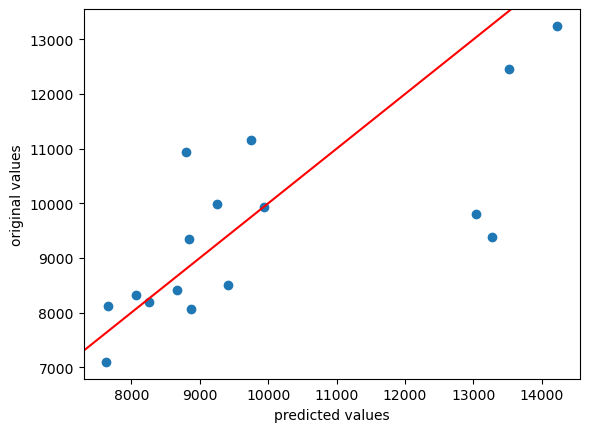

In [66]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y_te_pred_lr, y_test)
plt.xlabel("predicted values")
plt.ylabel("original values")
ax.axline((8000, 8000), slope=1, color = 'red')
plt.show()

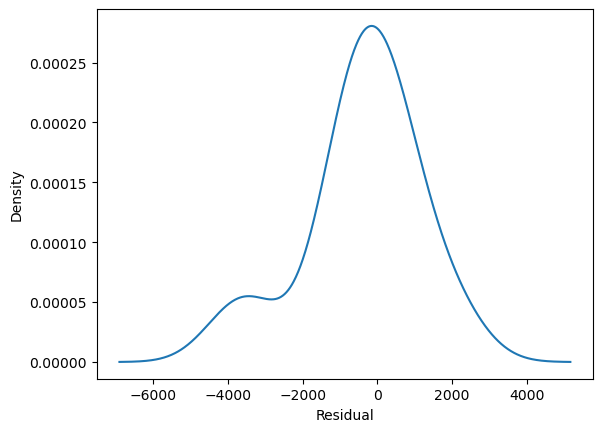

In [67]:
# Residual = actual - predicted
y_resid_lr = y_test - y_te_pred_lr
y_resid_lr.plot(kind='kde') #Kernel Distribution Estimation Plot
plt.xlabel("Residual")
plt.show()

### 4.8.3 Random Forest model<a id='4.8.3'></a>

In [68]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [69]:
RF_pipe.fit(X_train, y_train)

y_tr_pred = RF_pipe.predict(X_train)
y_te_pred = RF_pipe.predict(X_test)

r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.9526611818485465, -0.09332736115190654)

In [70]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [71]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [72]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [73]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 143,
 'standardscaler': StandardScaler()}

In [74]:
# RF model_best estimator performance on the test set: 
rf_grid_cv.best_estimator_.fit(X_train, y_train)

y_tr_pred_rf = rf_grid_cv.best_estimator_.predict(X_train)
y_te_pred_rf = rf_grid_cv.best_estimator_.predict(X_test)

r2_score(y_train, y_tr_pred_rf), r2_score(y_test, y_te_pred_rf)

(0.9548661999916019, -0.09235622082832107)

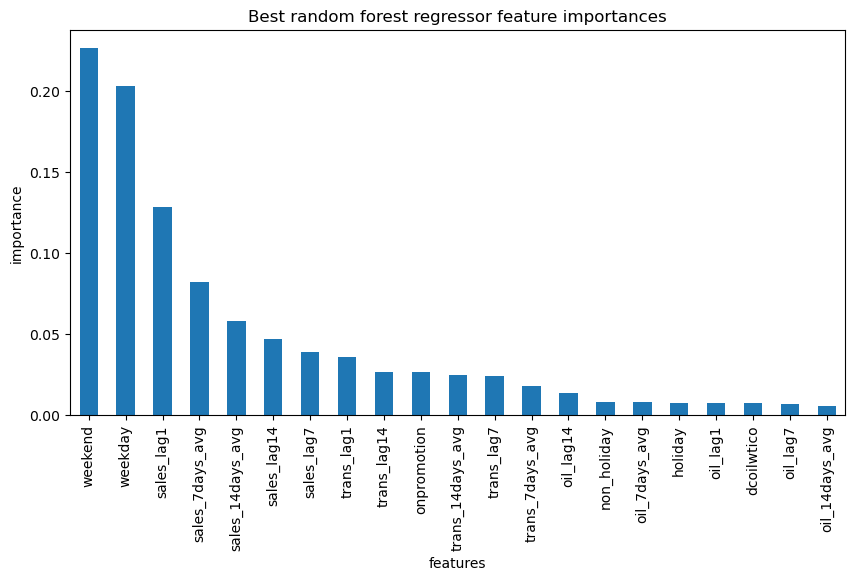

In [75]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [76]:
y_te_pred_rf = rf_grid_cv.best_estimator_.predict(X_test)

APE_rf = abs( (y_te_pred_rf - y_test) / y_test)
mAPE_rf = np.mean(APE_rf)
mAPE_rf

0.11983194889048585

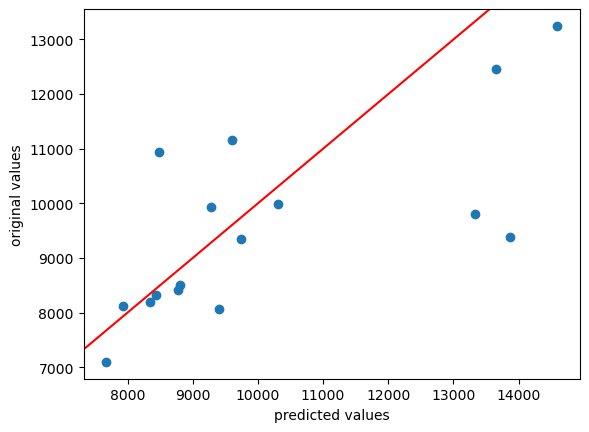

In [77]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y_te_pred_rf, y_test)
plt.xlabel("predicted values")
plt.ylabel("original values")
ax.axline((8000, 8000), slope=1, color = 'red')
plt.show()

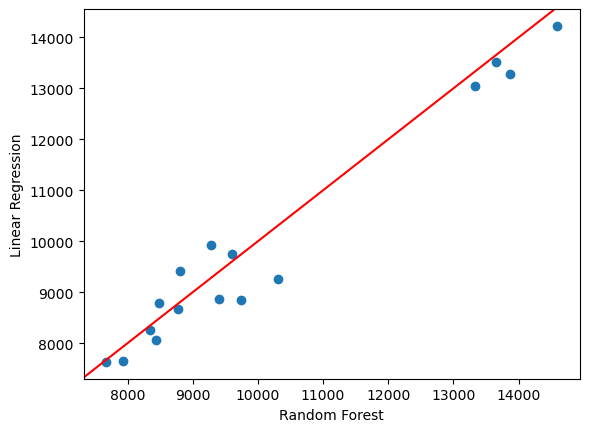

In [78]:
# LR vs RF scatterplot
fig, ax = plt.subplots()
ax.scatter(y_te_pred_rf, y_te_pred_lr)
plt.xlabel("Random Forest")
plt.ylabel("Linear Regression")
ax.axline((8000, 8000), slope=1, color = 'red')
plt.show()

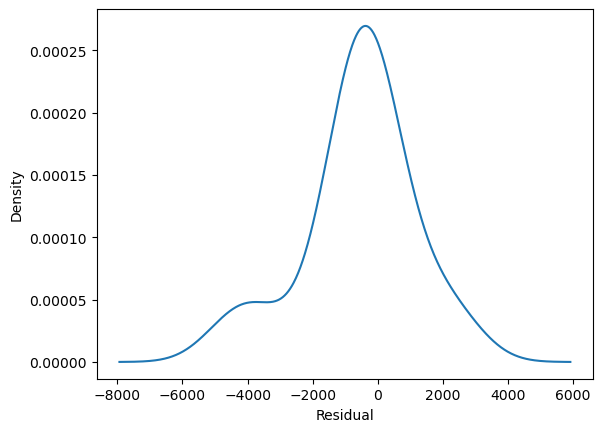

In [79]:
# Residual = actual - predicted
y_resid_rf = y_test - y_te_pred_rf
y_resid_rf.plot(kind='kde') #Kernel Distribution Estimation Plot
plt.xlabel("Residual")
plt.show()

**Brief Summary:**

The most important features from both linear regression and random forest models are: `weekend`, `weekday`, `sales_lag1` (previous day's sales), `sales_7days_avg` (average sales for the previous week).

The Linear Regression and Random Forest models have a MAPE of about 11% and 12%, respectively.

## 4.9 Models' Performance Comparison<a id='4.9'></a>

In [80]:
MAPE = {'model': ["MA(14)", "Linear Regression", "Random Forest"], 
        'MAPE': ['{:.1%}'.format(mAPE_ma), '{:.1%}'.format(mAPE_lr), '{:.1%}'.format(mAPE_rf)]}
df_MAPE = pd.DataFrame(data=MAPE)
df_MAPE

,model,MAPE
0,MA(14),10.5%
1,Linear Regression,11.0%
2,Random Forest,12.0%


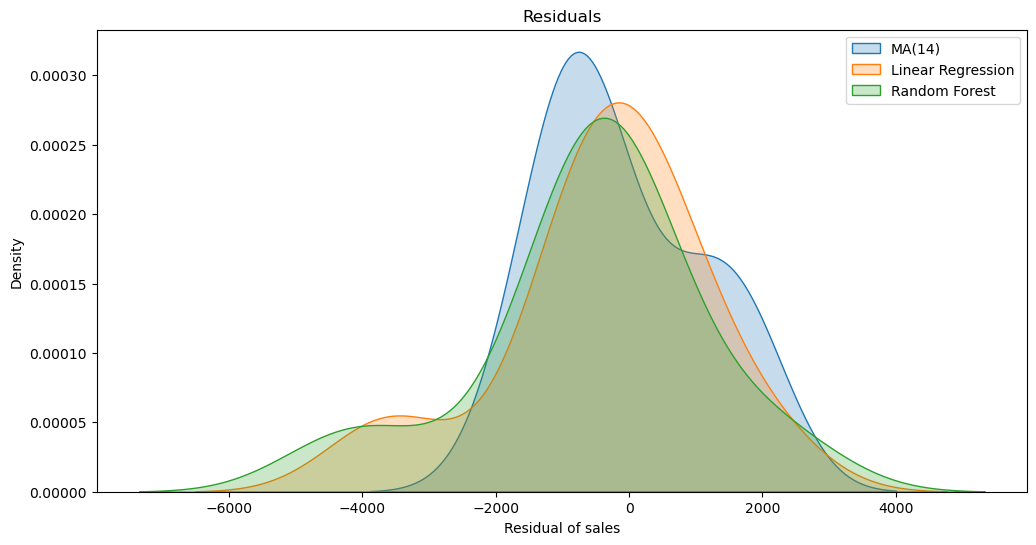

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=y_resid_ma,
            label='MA(14)', fill=True, ax=ax)
sns.kdeplot(data=y_resid_lr,
            label='Linear Regression', fill=True, ax=ax)
sns.kdeplot(data=y_resid_rf,
            label='Random Forest', fill=True, ax=ax)
ax.legend()
plt.title("Residuals")
plt.xlabel("Residual of sales")
plt.show()